In [13]:
import os
import glob
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord, ICRS
from astropy import constants as const
import matplotlib.pyplot as plt

In [14]:
def deg_GBT(sep,cfreq,diam=100.0 * u.m):
    """ Calculate degradation given angular separation, center frequency
    
    This calculation assumes the beam's sensitivity pattern is well-approximated by a
    Gaussian function. The default diameter is for the GBT and the beam's full width at
    half max is calculated using FWHM = 1.2*lamda/eff_diam rad.
    
    Parameters
    ==========
    sep: quantity, separation between observed/actual positions (arcmin)
    cfreq: quantity, center frequency of observation (MHz)
    diam: optional quantity, effective diameter of telescope (meters)
    
    Returns
    =======
    deg: float, estimated degradation to sensitivity based on separation
    """
    lamda = const.c/cfreq
    fwhm = 1.2*(lamda/diam*u.rad).to(u.arcmin)
    sig = fwhm/2.35482 # (solve for sigma when amplitude is 1/2; see wiki)
    
    return np.exp(-(sep/sig)**2/2)

In [15]:
def deg_AO(sep,cfreq,diam=300.0 * u.m):
    """ Calculate degradation given angular separation, center frequency
    
    This calculation assumes the beam's sensitivity pattern is well-approximated by a
    Gaussian function. The default diameter is for AO and the beam's full width at
    half max is calculated using FWHM = 1.2*lamda/eff_diam rad.
    
    Parameters
    ==========
    sep: quantity, separation between observed/actual positions (arcmin)
    cfreq: quantity, center frequency of observation (MHz)
    diam: optional quantity, effective diameter of telescope (meters)
    
    Returns
    =======
    deg: float, estimated degradation to sensitivity based on separation
    """
    lamda = const.c/cfreq
    fwhm = 1.2*(lamda/diam*u.rad).to(u.arcmin)
    sig = fwhm/2.35482 # (solve for sigma when amplitude is 1/2; see wiki)
    
    return np.exp(-(sep/sig)**2/2)

In [16]:
def deg_LOFAR(sep,fwhm=5 * u.arcmin):
    """ Calculate degradation given angular separation
    
    This calculation assumes the beam's sensitivity pattern is well-approximated by a
    Gaussian function. 
    
    The default FWHM is 5 arcmin: https://www.astron.nl/lofarscience2013/presentations/Session2_hessels.pdf page 8
    
    Parameters
    ==========
    sep: quantity, separation between observed/actual positions (arcmin)
    fwhm: optional quantity, full-width half-maximum of the telescope beam (arcmin)
    
    Returns
    =======
    deg: float, estimated degradation to sensitivity based on separation
    """
    sig = fwhm.to(u.arcmin)/2.35482 # (solve for sigma when amplitude is 1/2; see wiki)
    
    return np.exp(-(sep/sig)**2/2)

In [17]:
def deg_LWA1(sep,fwhm=2 * u.deg):
    """ Calculate degradation given angular separation
    
    This calculation assumes the beam's sensitivity pattern is well-approximated by a
    Gaussian function. 
    
    The default FWHM is 2 degrees, the value for the very top of the usable LWA1 band 
    around 80 MHz (Taylor et al. 2012)
    
    Parameters
    ==========
    sep: quantity, separation between observed/actual positions (arcmin)
    fwhm: optional quantity, full-width half-maximum of the telescope beam (degrees)
    
    Returns
    =======
    deg: float, estimated degradation to sensitivity based on separation
    """
    sig = fwhm.to(u.arcmin)/2.35482 # (solve for sigma when amplitude is 1/2; see wiki)
    
    return np.exp(-(sep/sig)**2/2)

In [18]:
print(deg_GBT(sep=7*u.arcmin,cfreq=350*u.MHz))

0.8969014572427696


PSR J0032+6946 was observed 81 times


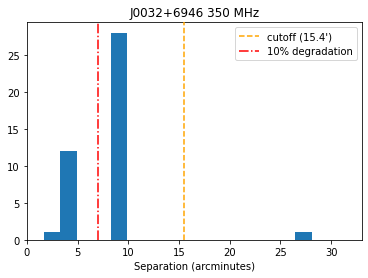

  41 time(s) at 350 MHz within 15.4 arcmin of the timing position (42 total)
J0032+6946 350.0 13398.372
  Min separation at 350 MHz: 3.3 arcmin (deg = 0.98)
  Med separation at 350 MHz: 8.4 arcmin (deg = 0.85)
  Max separation at 350 MHz: 26.7 arcmin (deg = 0.21)
  Max separation at 350 MHz: 26.7 arcmin (deg = 0.21)
  Degradation factor at 350 MHz: 0.89
Writing J0032+6946_350.files


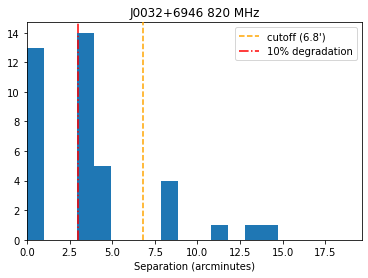

  32 time(s) at 820 MHz within 6.8 arcmin of the timing position (39 total)
J0032+6946 820.0 15567.103
  Min separation at 820 MHz: 0.0 arcmin (deg = 1.00)
  Med separation at 820 MHz: 3.8 arcmin (deg = 0.84)
  Max separation at 820 MHz: 14.5 arcmin (deg = 0.08)
  Max separation at 820 MHz: 14.5 arcmin (deg = 0.08)
  Degradation factor at 820 MHz: 0.89
Writing J0032+6946_820.files
PSR J0141+6303 was observed 37 times


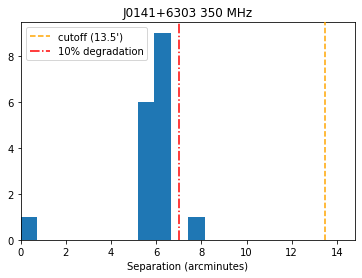

  17 time(s) at 350 MHz within 13.5 arcmin of the timing position (17 total)
J0141+6303 350.0 7352.379
  Min separation at 350 MHz: 0.0 arcmin (deg = 1.00)
  Med separation at 350 MHz: 6.5 arcmin (deg = 0.91)
  Max separation at 350 MHz: 7.9 arcmin (deg = 0.87)
  Max separation at 350 MHz: 7.9 arcmin (deg = 0.87)
  Degradation factor at 350 MHz: 0.92
All observations of PSR J0141+6303 at 350 MHz within threshold.


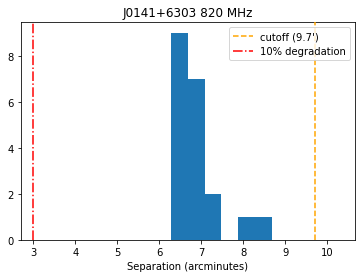

  20 time(s) at 820 MHz within 9.7 arcmin of the timing position (20 total)
J0141+6303 820.0 11156.844000000001
  Min separation at 820 MHz: 6.5 arcmin (deg = 0.60)
  Med separation at 820 MHz: 6.7 arcmin (deg = 0.58)
  Max separation at 820 MHz: 8.4 arcmin (deg = 0.42)
  Max separation at 820 MHz: 8.4 arcmin (deg = 0.42)
  Degradation factor at 820 MHz: 0.57
All observations of PSR J0141+6303 at 820 MHz within threshold.
PSR J0214+5222 was observed 57 times


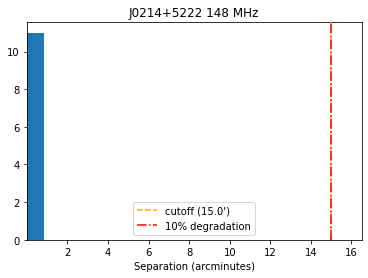

  11 time(s) at 149 MHz within 15.0 arcmin of the timing position (11 total)
J0214+5222 148.926 3296.6
  Min separation at 149 MHz: 0.0 arcmin (deg = 1.00)
  Med separation at 149 MHz: 0.0 arcmin (deg = 1.00)
  Max separation at 149 MHz: 0.0 arcmin (deg = 1.00)
  Max separation at 149 MHz: 0.0 arcmin (deg = 1.00)
  Degradation factor at 149 MHz: 1.00
All observations of PSR J0214+5222 at 149 MHz within threshold.


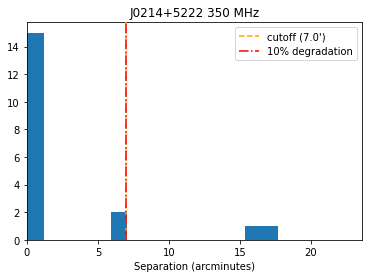

  15 time(s) at 350 MHz within 7.0 arcmin of the timing position (19 total)
J0214+5222 350.0 4890.389
  Min separation at 350 MHz: 0.0 arcmin (deg = 1.00)
  Med separation at 350 MHz: 0.0 arcmin (deg = 1.00)
  Max separation at 350 MHz: 16.7 arcmin (deg = 0.54)
  Max separation at 350 MHz: 16.7 arcmin (deg = 0.54)
  Degradation factor at 350 MHz: 1.00
Writing J0214+5222_350.files


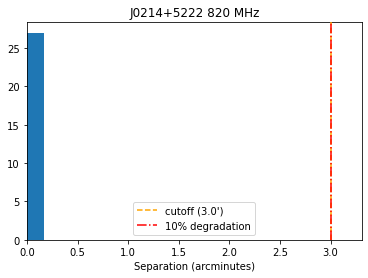

  27 time(s) at 820 MHz within 3.0 arcmin of the timing position (27 total)
J0214+5222 820.0 14395.719
  Min separation at 820 MHz: 0.0 arcmin (deg = 1.00)
  Med separation at 820 MHz: 0.0 arcmin (deg = 1.00)
  Max separation at 820 MHz: 0.0 arcmin (deg = 1.00)
  Max separation at 820 MHz: 0.0 arcmin (deg = 1.00)
  Degradation factor at 820 MHz: 1.00
All observations of PSR J0214+5222 at 820 MHz within threshold.
PSR J0415+6111 was observed 20 times
  1 time(s) at 350 MHz within 11.0 arcmin of the timing position (1 total)
J0415+6111 350.0 111.401
  Min separation at 350 MHz: 10.9 arcmin (deg = 0.77)
  Med separation at 350 MHz: 10.9 arcmin (deg = 0.77)
  Max separation at 350 MHz: 10.9 arcmin (deg = 0.77)
  Max separation at 350 MHz: 10.9 arcmin (deg = 0.77)
  Degradation factor at 350 MHz: 0.77
All observations of PSR J0415+6111 at 350 MHz within threshold.


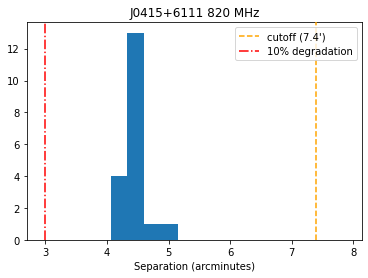

  19 time(s) at 820 MHz within 7.4 arcmin of the timing position (19 total)
J0415+6111 820.0 5428.933000000001
  Min separation at 820 MHz: 4.2 arcmin (deg = 0.81)
  Med separation at 820 MHz: 4.4 arcmin (deg = 0.79)
  Max separation at 820 MHz: 4.9 arcmin (deg = 0.75)
  Max separation at 820 MHz: 4.9 arcmin (deg = 0.75)
  Degradation factor at 820 MHz: 0.79
All observations of PSR J0415+6111 at 820 MHz within threshold.
PSR J0636+5128 was observed 75 times


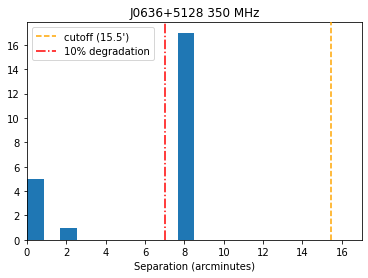

  23 time(s) at 350 MHz within 15.5 arcmin of the timing position (23 total)
J0636+5128 350.0 14738.272
  Min separation at 350 MHz: 0.0 arcmin (deg = 1.00)
  Med separation at 350 MHz: 8.5 arcmin (deg = 0.85)
  Max separation at 350 MHz: 8.5 arcmin (deg = 0.85)
  Max separation at 350 MHz: 8.5 arcmin (deg = 0.85)
  Degradation factor at 350 MHz: 0.90
All observations of PSR J0636+5128 at 350 MHz within threshold.


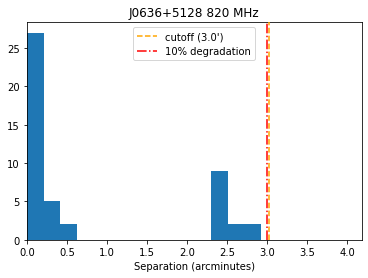

  47 time(s) at 820 MHz within 3.0 arcmin of the timing position (47 total)
J0636+5128 820.0 28626.813000000002
  Min separation at 820 MHz: 0.0 arcmin (deg = 1.00)
  Med separation at 820 MHz: 0.0 arcmin (deg = 1.00)
  Max separation at 820 MHz: 2.8 arcmin (deg = 0.91)
  Max separation at 820 MHz: 2.8 arcmin (deg = 0.91)
  Degradation factor at 820 MHz: 0.98
All observations of PSR J0636+5128 at 820 MHz within threshold.


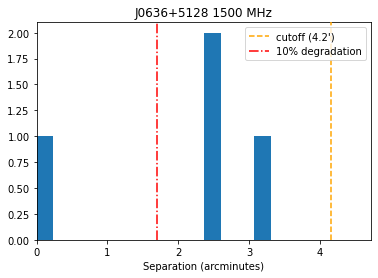

  4 time(s) at 1500 MHz within 4.2 arcmin of the timing position (4 total)
J0636+5128 1500.0 6770.469
  Min separation at 1500 MHz: 0.0 arcmin (deg = 1.00)
  Med separation at 1500 MHz: 2.5 arcmin (deg = 0.78)
  Max separation at 1500 MHz: 3.2 arcmin (deg = 0.66)
  Max separation at 1500 MHz: 3.2 arcmin (deg = 0.66)
  Degradation factor at 1500 MHz: 0.90
All observations of PSR J0636+5128 at 1500 MHz within threshold.
  1 time(s) at 2000 MHz within 0.1 arcmin of the timing position (1 total)
J0636+5128 2000.0 5401.487
  Min separation at 2000 MHz: 0.0 arcmin (deg = 1.00)
  Med separation at 2000 MHz: 0.0 arcmin (deg = 1.00)
  Max separation at 2000 MHz: 0.0 arcmin (deg = 1.00)
  Max separation at 2000 MHz: 0.0 arcmin (deg = 1.00)
  Degradation factor at 2000 MHz: 1.00
All observations of PSR J0636+5128 at 2000 MHz within threshold.
PSR J0957-0619 was observed 19 times
  1 time(s) at 350 MHz within 2.4 arcmin of the timing position (1 total)
J0957-0619 350.0 151.163
  Min separation at 

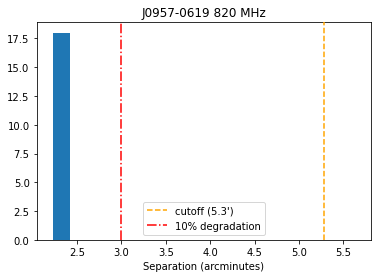

  18 time(s) at 820 MHz within 5.3 arcmin of the timing position (18 total)
J0957-0619 820.0 10471.999
  Min separation at 820 MHz: 2.3 arcmin (deg = 0.94)
  Med separation at 820 MHz: 2.3 arcmin (deg = 0.94)
  Max separation at 820 MHz: 2.3 arcmin (deg = 0.94)
  Max separation at 820 MHz: 2.3 arcmin (deg = 0.94)
  Degradation factor at 820 MHz: 0.94
All observations of PSR J0957-0619 at 820 MHz within threshold.
PSR J1239+3239 was observed 50 times


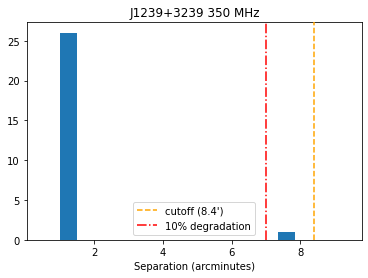

  27 time(s) at 350 MHz within 8.4 arcmin of the timing position (27 total)
J1239+3239 350.0 12075.010999999999
  Min separation at 350 MHz: 1.4 arcmin (deg = 1.00)
  Med separation at 350 MHz: 1.4 arcmin (deg = 1.00)
  Max separation at 350 MHz: 7.8 arcmin (deg = 0.87)
  Max separation at 350 MHz: 7.8 arcmin (deg = 0.87)
  Degradation factor at 350 MHz: 0.99
All observations of PSR J1239+3239 at 350 MHz within threshold.


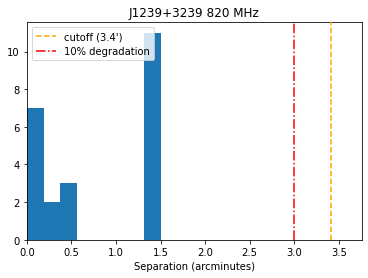

  23 time(s) at 820 MHz within 3.4 arcmin of the timing position (23 total)
J1239+3239 820.0 13179.083999999999
  Min separation at 820 MHz: 0.1 arcmin (deg = 1.00)
  Med separation at 820 MHz: 0.4 arcmin (deg = 1.00)
  Max separation at 820 MHz: 1.4 arcmin (deg = 0.98)
  Max separation at 820 MHz: 1.4 arcmin (deg = 0.98)
  Degradation factor at 820 MHz: 0.99
All observations of PSR J1239+3239 at 820 MHz within threshold.
PSR J1327+3423 was observed 136 times


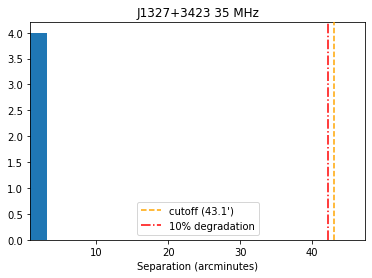

  4 time(s) at 35 MHz within 43.1 arcmin of the timing position (4 total)
J1327+3423 35.1 14437.956
  Min separation at 35 MHz: 0.9 arcmin (deg = 1.00)
  Med separation at 35 MHz: 0.9 arcmin (deg = 1.00)
  Max separation at 35 MHz: 0.9 arcmin (deg = 1.00)
  Max separation at 35 MHz: 0.9 arcmin (deg = 1.00)
  Degradation factor at 35 MHz: 1.00
All observations of PSR J1327+3423 at 35.1 MHz within threshold.


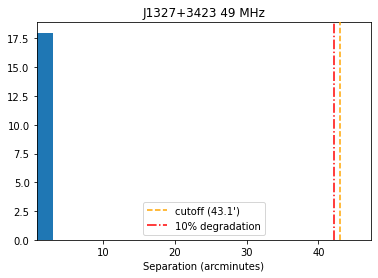

  18 time(s) at 50 MHz within 43.1 arcmin of the timing position (18 total)
J1327+3423 49.8 61508.239
  Min separation at 50 MHz: 0.9 arcmin (deg = 1.00)
  Med separation at 50 MHz: 0.9 arcmin (deg = 1.00)
  Max separation at 50 MHz: 0.9 arcmin (deg = 1.00)
  Max separation at 50 MHz: 0.9 arcmin (deg = 1.00)
  Degradation factor at 50 MHz: 1.00
All observations of PSR J1327+3423 at 49.8 MHz within threshold.


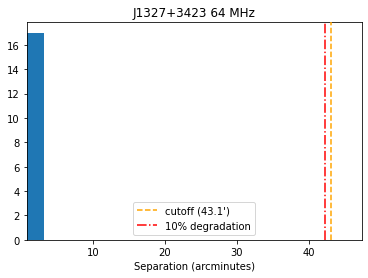

  17 time(s) at 64 MHz within 43.1 arcmin of the timing position (17 total)
J1327+3423 64.5 57802.215
  Min separation at 64 MHz: 0.9 arcmin (deg = 1.00)
  Med separation at 64 MHz: 0.9 arcmin (deg = 1.00)
  Max separation at 64 MHz: 0.9 arcmin (deg = 1.00)
  Max separation at 64 MHz: 0.9 arcmin (deg = 1.00)
  Degradation factor at 64 MHz: 1.00
All observations of PSR J1327+3423 at 64.5 MHz within threshold.


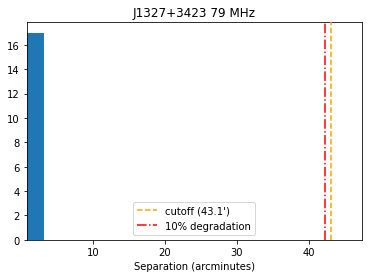

  17 time(s) at 79 MHz within 43.1 arcmin of the timing position (17 total)
J1327+3423 79.2 57802.879
  Min separation at 79 MHz: 0.9 arcmin (deg = 1.00)
  Med separation at 79 MHz: 0.9 arcmin (deg = 1.00)
  Max separation at 79 MHz: 0.9 arcmin (deg = 1.00)
  Max separation at 79 MHz: 0.9 arcmin (deg = 1.00)
  Degradation factor at 79 MHz: 1.00
All observations of PSR J1327+3423 at 79.2 MHz within threshold.


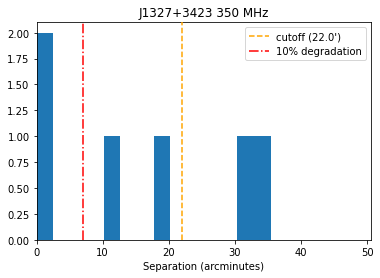

  4 time(s) at 350 MHz within 22.0 arcmin of the timing position (6 total)
J1327+3423 350.0 1421.7020000000002
  Min separation at 350 MHz: 0.3 arcmin (deg = 1.00)
  Med separation at 350 MHz: 15.0 arcmin (deg = 0.61)
  Max separation at 350 MHz: 33.8 arcmin (deg = 0.08)
  Max separation at 350 MHz: 33.8 arcmin (deg = 0.08)
  Degradation factor at 350 MHz: 0.88
Writing J1327+3423_350.files


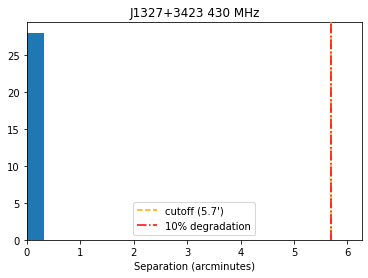

  28 time(s) at 430 MHz within 5.7 arcmin of the timing position (28 total)
J1327+3423 430.0 31812.843999999997
  Min separation at 430 MHz: 0.0 arcmin (deg = 1.00)
  Med separation at 430 MHz: 0.0 arcmin (deg = 1.00)
  Max separation at 430 MHz: 0.0 arcmin (deg = 1.00)
  Max separation at 430 MHz: 0.0 arcmin (deg = 1.00)
  Degradation factor at 430 MHz: 1.00
All observations of PSR J1327+3423 at 430 MHz within threshold.


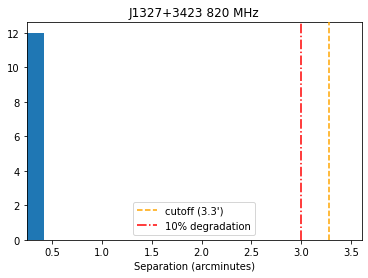

  12 time(s) at 820 MHz within 3.3 arcmin of the timing position (12 total)
J1327+3423 820.0 9373.748
  Min separation at 820 MHz: 0.3 arcmin (deg = 1.00)
  Med separation at 820 MHz: 0.3 arcmin (deg = 1.00)
  Max separation at 820 MHz: 0.3 arcmin (deg = 1.00)
  Max separation at 820 MHz: 0.3 arcmin (deg = 1.00)
  Degradation factor at 820 MHz: 1.00
All observations of PSR J1327+3423 at 820 MHz within threshold.


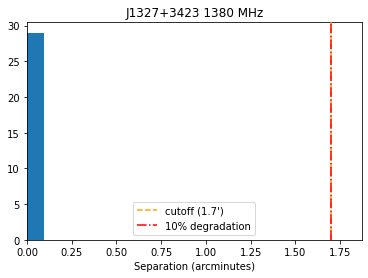

  29 time(s) at 1380 MHz within 1.7 arcmin of the timing position (29 total)
J1327+3423 1380.0 30238.022999999997
  Min separation at 1380 MHz: 0.0 arcmin (deg = 1.00)
  Med separation at 1380 MHz: 0.0 arcmin (deg = 1.00)
  Max separation at 1380 MHz: 0.0 arcmin (deg = 1.00)
  Max separation at 1380 MHz: 0.0 arcmin (deg = 1.00)
  Degradation factor at 1380 MHz: 1.00
All observations of PSR J1327+3423 at 1380 MHz within threshold.
  1 time(s) at 1430 MHz within 0.1 arcmin of the timing position (1 total)
J1327+3423 1430.0 358.732
  Min separation at 1430 MHz: 0.0 arcmin (deg = 1.00)
  Med separation at 1430 MHz: 0.0 arcmin (deg = 1.00)
  Max separation at 1430 MHz: 0.0 arcmin (deg = 1.00)
  Max separation at 1430 MHz: 0.0 arcmin (deg = 1.00)
  Degradation factor at 1430 MHz: 1.00
All observations of PSR J1327+3423 at 1380 MHz within threshold.
PSR J1434+7257 was observed 82 times


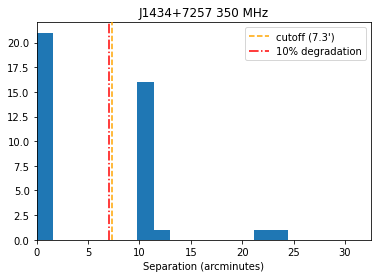

  21 time(s) at 350 MHz within 7.3 arcmin of the timing position (40 total)
J1434+7257 350.0 7565.455
  Min separation at 350 MHz: 0.0 arcmin (deg = 1.00)
  Med separation at 350 MHz: 0.3 arcmin (deg = 1.00)
  Max separation at 350 MHz: 23.7 arcmin (deg = 0.29)
  Max separation at 350 MHz: 23.7 arcmin (deg = 0.29)
  Degradation factor at 350 MHz: 1.00
Writing J1434+7257_350.files


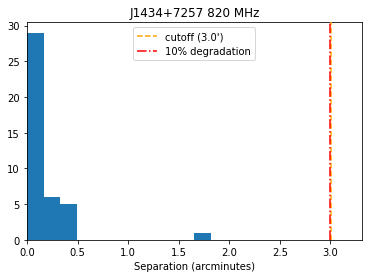

  41 time(s) at 820 MHz within 3.0 arcmin of the timing position (41 total)
J1434+7257 820.0 16370.917
  Min separation at 820 MHz: 0.0 arcmin (deg = 1.00)
  Med separation at 820 MHz: 0.0 arcmin (deg = 1.00)
  Max separation at 820 MHz: 1.8 arcmin (deg = 0.96)
  Max separation at 820 MHz: 1.8 arcmin (deg = 0.96)
  Degradation factor at 820 MHz: 1.00
All observations of PSR J1434+7257 at 820 MHz within threshold.
  1 time(s) at 1500 MHz within 0.1 arcmin of the timing position (1 total)
J1434+7257 1500.0 594.463
  Min separation at 1500 MHz: 0.0 arcmin (deg = 1.00)
  Med separation at 1500 MHz: 0.0 arcmin (deg = 1.00)
  Max separation at 1500 MHz: 0.0 arcmin (deg = 1.00)
  Max separation at 1500 MHz: 0.0 arcmin (deg = 1.00)
  Degradation factor at 1500 MHz: 1.00
All observations of PSR J1434+7257 at 1500 MHz within threshold.
PSR J1505-2524 was observed 26 times


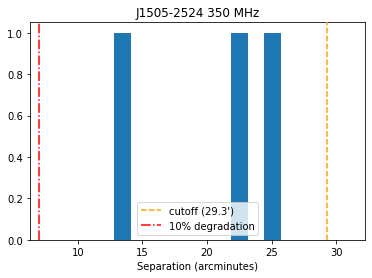

  3 time(s) at 350 MHz within 29.3 arcmin of the timing position (3 total)
J1505-2524 350.0 334.203
  Min separation at 350 MHz: 12.9 arcmin (deg = 0.69)
  Med separation at 350 MHz: 22.3 arcmin (deg = 0.33)
  Max separation at 350 MHz: 24.6 arcmin (deg = 0.26)
  Max separation at 350 MHz: 24.6 arcmin (deg = 0.26)
  Degradation factor at 350 MHz: 0.43
All observations of PSR J1505-2524 at 350 MHz within threshold.


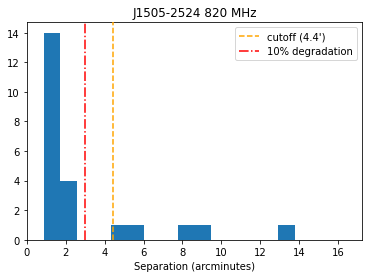

  19 time(s) at 820 MHz within 4.4 arcmin of the timing position (23 total)
J1505-2524 820.0 6465.7660000000005
  Min separation at 820 MHz: 1.1 arcmin (deg = 0.99)
  Med separation at 820 MHz: 1.4 arcmin (deg = 0.98)
  Max separation at 820 MHz: 12.9 arcmin (deg = 0.13)
  Max separation at 820 MHz: 12.9 arcmin (deg = 0.13)
  Degradation factor at 820 MHz: 0.96
Writing J1505-2524_820.files
PSR J1530-2114 was observed 32 times


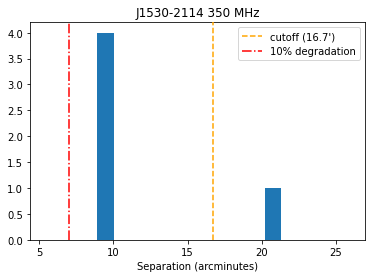

  4 time(s) at 350 MHz within 16.7 arcmin of the timing position (5 total)
J1530-2114 350.0 1774.3600000000001
  Min separation at 350 MHz: 9.7 arcmin (deg = 0.81)
  Med separation at 350 MHz: 9.7 arcmin (deg = 0.81)
  Max separation at 350 MHz: 20.6 arcmin (deg = 0.39)
  Max separation at 350 MHz: 20.6 arcmin (deg = 0.39)
  Degradation factor at 350 MHz: 0.81
Writing J1530-2114_350.files


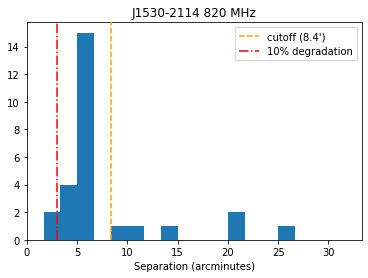

  21 time(s) at 820 MHz within 8.4 arcmin of the timing position (27 total)
J1530-2114 820.0 7945.851000000001
  Min separation at 820 MHz: 3.1 arcmin (deg = 0.89)
  Med separation at 820 MHz: 5.4 arcmin (deg = 0.71)
  Max separation at 820 MHz: 25.1 arcmin (deg = 0.00)
  Max separation at 820 MHz: 25.1 arcmin (deg = 0.00)
  Degradation factor at 820 MHz: 0.74
Writing J1530-2114_820.files
PSR J1816+4510 was observed 87 times


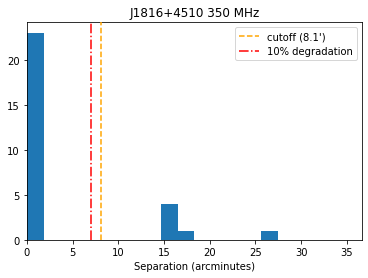

  23 time(s) at 350 MHz within 8.1 arcmin of the timing position (29 total)
J1816+4510 350.0 8737.2
  Min separation at 350 MHz: 0.0 arcmin (deg = 1.00)
  Med separation at 350 MHz: 1.1 arcmin (deg = 1.00)
  Max separation at 350 MHz: 26.6 arcmin (deg = 0.21)
  Max separation at 350 MHz: 26.6 arcmin (deg = 0.21)
  Degradation factor at 350 MHz: 1.00
Writing J1816+4510_350.files


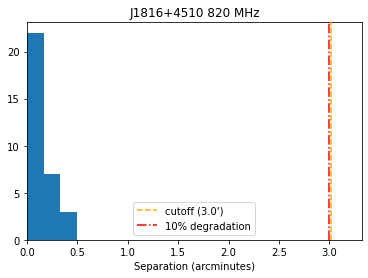

  32 time(s) at 820 MHz within 3.0 arcmin of the timing position (32 total)
J1816+4510 820.0 48013.944
  Min separation at 820 MHz: 0.0 arcmin (deg = 1.00)
  Med separation at 820 MHz: 0.0 arcmin (deg = 1.00)
  Max separation at 820 MHz: 0.4 arcmin (deg = 1.00)
  Max separation at 820 MHz: 0.4 arcmin (deg = 1.00)
  Degradation factor at 820 MHz: 1.00
All observations of PSR J1816+4510 at 820 MHz within threshold.


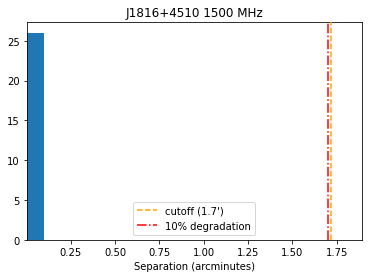

  26 time(s) at 1500 MHz within 1.7 arcmin of the timing position (26 total)
J1816+4510 1500.0 32098.686
  Min separation at 1500 MHz: 0.0 arcmin (deg = 1.00)
  Med separation at 1500 MHz: 0.0 arcmin (deg = 1.00)
  Max separation at 1500 MHz: 0.0 arcmin (deg = 1.00)
  Max separation at 1500 MHz: 0.0 arcmin (deg = 1.00)
  Degradation factor at 1500 MHz: 1.00
All observations of PSR J1816+4510 at 1500 MHz within threshold.
PSR J1913+3732 was observed 28 times


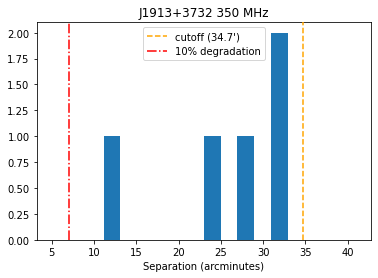

  5 time(s) at 350 MHz within 34.7 arcmin of the timing position (5 total)
J1913+3732 350.0 546.878
  Min separation at 350 MHz: 11.7 arcmin (deg = 0.74)
  Med separation at 350 MHz: 27.7 arcmin (deg = 0.18)
  Max separation at 350 MHz: 32.2 arcmin (deg = 0.10)
  Max separation at 350 MHz: 32.2 arcmin (deg = 0.10)
  Degradation factor at 350 MHz: 0.28
All observations of PSR J1913+3732 at 350 MHz within threshold.


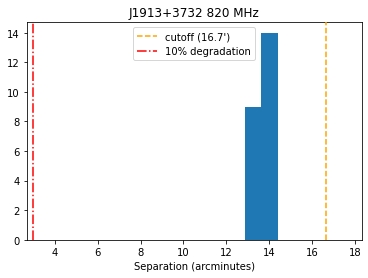

  23 time(s) at 820 MHz within 16.7 arcmin of the timing position (23 total)
J1913+3732 820.0 8691.08
  Min separation at 820 MHz: 13.1 arcmin (deg = 0.12)
  Med separation at 820 MHz: 13.7 arcmin (deg = 0.10)
  Max separation at 820 MHz: 14.1 arcmin (deg = 0.09)
  Max separation at 820 MHz: 14.1 arcmin (deg = 0.09)
  Degradation factor at 820 MHz: 0.10
All observations of PSR J1913+3732 at 820 MHz within threshold.
PSR J1929+6630 was observed 22 times


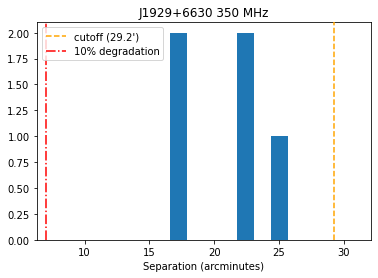

  5 time(s) at 350 MHz within 29.2 arcmin of the timing position (5 total)
J1929+6630 350.0 748.265
  Min separation at 350 MHz: 17.8 arcmin (deg = 0.49)
  Med separation at 350 MHz: 22.2 arcmin (deg = 0.33)
  Max separation at 350 MHz: 25.4 arcmin (deg = 0.24)
  Max separation at 350 MHz: 25.4 arcmin (deg = 0.24)
  Degradation factor at 350 MHz: 0.39
All observations of PSR J1929+6630 at 350 MHz within threshold.


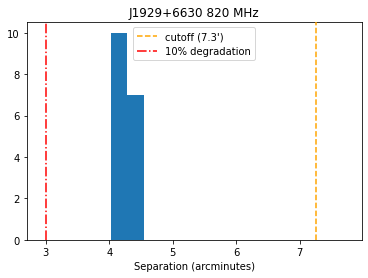

  17 time(s) at 820 MHz within 7.3 arcmin of the timing position (17 total)
J1929+6630 820.0 4784.353
  Min separation at 820 MHz: 4.1 arcmin (deg = 0.82)
  Med separation at 820 MHz: 4.3 arcmin (deg = 0.80)
  Max separation at 820 MHz: 4.5 arcmin (deg = 0.78)
  Max separation at 820 MHz: 4.5 arcmin (deg = 0.78)
  Degradation factor at 820 MHz: 0.80
All observations of PSR J1929+6630 at 820 MHz within threshold.
PSR J1930+6205 was observed 20 times


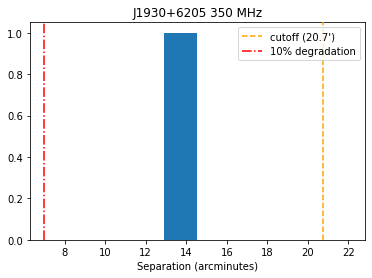

  2 time(s) at 350 MHz within 20.7 arcmin of the timing position (2 total)
J1930+6205 350.0 605.322
  Min separation at 350 MHz: 13.1 arcmin (deg = 0.68)
  Med separation at 350 MHz: 13.7 arcmin (deg = 0.66)
  Max separation at 350 MHz: 14.4 arcmin (deg = 0.63)
  Max separation at 350 MHz: 14.4 arcmin (deg = 0.63)
  Degradation factor at 350 MHz: 0.66
All observations of PSR J1930+6205 at 350 MHz within threshold.


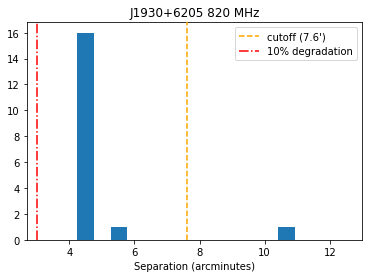

  17 time(s) at 820 MHz within 7.6 arcmin of the timing position (18 total)
J1930+6205 820.0 4784.353
  Min separation at 820 MHz: 4.6 arcmin (deg = 0.77)
  Med separation at 820 MHz: 4.6 arcmin (deg = 0.77)
  Max separation at 820 MHz: 10.6 arcmin (deg = 0.26)
  Max separation at 820 MHz: 10.6 arcmin (deg = 0.26)
  Degradation factor at 820 MHz: 0.77
Writing J1930+6205_820.files
PSR J2104+2830 was observed 21 times


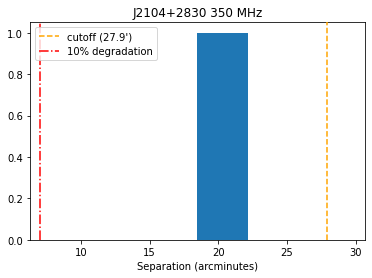

  3 time(s) at 350 MHz within 27.9 arcmin of the timing position (3 total)
J2104+2830 350.0 344.269
  Min separation at 350 MHz: 18.6 arcmin (deg = 0.46)
  Med separation at 350 MHz: 20.9 arcmin (deg = 0.38)
  Max separation at 350 MHz: 21.8 arcmin (deg = 0.35)
  Max separation at 350 MHz: 21.8 arcmin (deg = 0.35)
  Degradation factor at 350 MHz: 0.40
All observations of PSR J2104+2830 at 350 MHz within threshold.


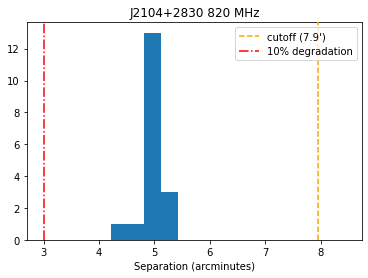

  18 time(s) at 820 MHz within 7.9 arcmin of the timing position (18 total)
J2104+2830 820.0 5136.842000000001
  Min separation at 820 MHz: 4.5 arcmin (deg = 0.78)
  Med separation at 820 MHz: 4.9 arcmin (deg = 0.74)
  Max separation at 820 MHz: 5.4 arcmin (deg = 0.70)
  Max separation at 820 MHz: 5.4 arcmin (deg = 0.70)
  Degradation factor at 820 MHz: 0.74
All observations of PSR J2104+2830 at 820 MHz within threshold.
PSR J2115+6702 was observed 16 times
  1 time(s) at 350 MHz within 8.7 arcmin of the timing position (1 total)
J2115+6702 350.0 111.401
  Min separation at 350 MHz: 8.6 arcmin (deg = 0.85)
  Med separation at 350 MHz: 8.6 arcmin (deg = 0.85)
  Max separation at 350 MHz: 8.6 arcmin (deg = 0.85)
  Max separation at 350 MHz: 8.6 arcmin (deg = 0.85)
  Degradation factor at 350 MHz: 0.85
All observations of PSR J2115+6702 at 350 MHz within threshold.


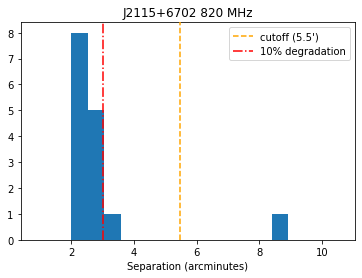

  14 time(s) at 820 MHz within 5.5 arcmin of the timing position (15 total)
J2115+6702 820.0 5418.030000000001
  Min separation at 820 MHz: 2.2 arcmin (deg = 0.95)
  Med separation at 820 MHz: 2.5 arcmin (deg = 0.93)
  Max separation at 820 MHz: 8.6 arcmin (deg = 0.40)
  Max separation at 820 MHz: 8.6 arcmin (deg = 0.40)
  Degradation factor at 820 MHz: 0.92
Writing J2115+6702_820.files
PSR J2145+2158 was observed 14 times
  1 time(s) at 350 MHz within 15.5 arcmin of the timing position (1 total)
J2145+2158 350.0 30.87
  Min separation at 350 MHz: 15.4 arcmin (deg = 0.59)
  Med separation at 350 MHz: 15.4 arcmin (deg = 0.59)
  Max separation at 350 MHz: 15.4 arcmin (deg = 0.59)
  Max separation at 350 MHz: 15.4 arcmin (deg = 0.59)
  Degradation factor at 350 MHz: 0.59
All observations of PSR J2145+2158 at 350 MHz within threshold.


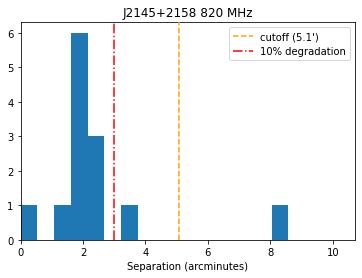

  12 time(s) at 820 MHz within 5.1 arcmin of the timing position (13 total)
J2145+2158 820.0 2386.2249999999995
  Min separation at 820 MHz: 0.3 arcmin (deg = 1.00)
  Med separation at 820 MHz: 2.1 arcmin (deg = 0.95)
  Max separation at 820 MHz: 8.2 arcmin (deg = 0.44)
  Max separation at 820 MHz: 8.2 arcmin (deg = 0.44)
  Degradation factor at 820 MHz: 0.95
Writing J2145+2158_820.files
PSR J2210+5712 was observed 21 times
  1 time(s) at 350 MHz within 17.7 arcmin of the timing position (1 total)
J2210+5712 350.0 111.401
  Min separation at 350 MHz: 17.6 arcmin (deg = 0.50)
  Med separation at 350 MHz: 17.6 arcmin (deg = 0.50)
  Max separation at 350 MHz: 17.6 arcmin (deg = 0.50)
  Max separation at 350 MHz: 17.6 arcmin (deg = 0.50)
  Degradation factor at 350 MHz: 0.50
All observations of PSR J2210+5712 at 350 MHz within threshold.


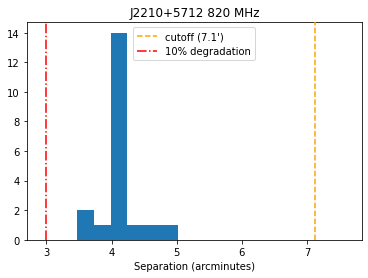

  20 time(s) at 820 MHz within 7.1 arcmin of the timing position (20 total)
J2210+5712 820.0 5662.472000000002
  Min separation at 820 MHz: 3.7 arcmin (deg = 0.85)
  Med separation at 820 MHz: 4.1 arcmin (deg = 0.81)
  Max separation at 820 MHz: 4.9 arcmin (deg = 0.75)
  Max separation at 820 MHz: 4.9 arcmin (deg = 0.75)
  Degradation factor at 820 MHz: 0.81
All observations of PSR J2210+5712 at 820 MHz within threshold.
PSR J2326+6243 was observed 22 times
  1 time(s) at 350 MHz within 6.4 arcmin of the timing position (1 total)
J2326+6243 350.0 111.401
  Min separation at 350 MHz: 6.3 arcmin (deg = 0.91)
  Med separation at 350 MHz: 6.3 arcmin (deg = 0.91)
  Max separation at 350 MHz: 6.3 arcmin (deg = 0.91)
  Max separation at 350 MHz: 6.3 arcmin (deg = 0.91)
  Degradation factor at 350 MHz: 0.91
All observations of PSR J2326+6243 at 350 MHz within threshold.


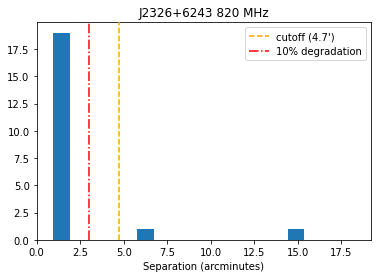

  19 time(s) at 820 MHz within 4.7 arcmin of the timing position (21 total)
J2326+6243 820.0 5428.933000000001
  Min separation at 820 MHz: 1.2 arcmin (deg = 0.98)
  Med separation at 820 MHz: 1.7 arcmin (deg = 0.96)
  Max separation at 820 MHz: 14.8 arcmin (deg = 0.07)
  Max separation at 820 MHz: 14.8 arcmin (deg = 0.07)
  Degradation factor at 820 MHz: 0.97
Writing J2326+6243_820.files
PSR J2354-2250 was observed 22 times


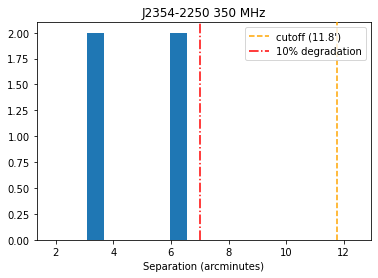

  4 time(s) at 350 MHz within 11.8 arcmin of the timing position (4 total)
J2354-2250 350.0 1783.923
  Min separation at 350 MHz: 3.2 arcmin (deg = 0.98)
  Med separation at 350 MHz: 4.8 arcmin (deg = 0.95)
  Max separation at 350 MHz: 6.3 arcmin (deg = 0.91)
  Max separation at 350 MHz: 6.3 arcmin (deg = 0.91)
  Degradation factor at 350 MHz: 0.95
All observations of PSR J2354-2250 at 350 MHz within threshold.


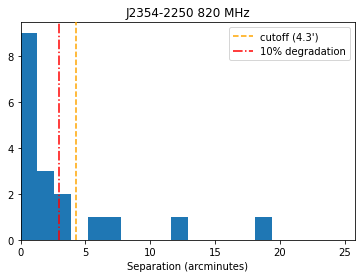

  14 time(s) at 820 MHz within 4.3 arcmin of the timing position (18 total)
J2354-2250 820.0 5820.684000000001
  Min separation at 820 MHz: 1.1 arcmin (deg = 0.98)
  Med separation at 820 MHz: 1.3 arcmin (deg = 0.98)
  Max separation at 820 MHz: 19.1 arcmin (deg = 0.01)
  Max separation at 820 MHz: 19.1 arcmin (deg = 0.01)
  Degradation factor at 820 MHz: 0.96
Writing J2354-2250_820.files


In [19]:
data_dir = "./"
deg_factors = []
psrsfreqs = []
pars = sorted(glob.glob(f"{data_dir}*fiore+23.par"))

lengths_file = open("lengths.dat","w")

PRINT_FILES = True

for p in pars:
    par_path = os.path.join(data_dir, p)
        
    # For each scan, get the RA/Dec and compare to timing position (eqcoord) 
    with open(p, 'r') as infile:
        for l in infile.readlines():
            if l.startswith("PSRJ"):
                psr = l.split()[1]
            elif l.startswith("RAJ"):
                ra_str = l.split()[1]
            elif l.startswith("DECJ"):
                dec_str = l.split()[1].strip("+")
            else:
                pass
    
    eqcoord = SkyCoord(ra_str,dec_str,frame=ICRS,unit=(u.hourangle, u.deg))
    
    mlfrd_path = os.path.join(data_dir,f"{psr}.mlfrd")
    
    # mfrd files contain MJD, length, center frequency, RA, Dec info for each scan for a given pulsar
    with open(mlfrd_path) as f:
        mlfrd_lines = f.readlines()
    
    fnames = []
    freqs = []
    obstime = 0
    separations = [] # gather angular separations (arcmins)
    degradations = [] # and calculate degradations based on telescope
    lengths = [] # used to weight degradation factor later
    for ml in mlfrd_lines:
        if ml.startswith(('GUPPI', 'guppi', 'VEGAS')):
            fname, mjd_str, len_str, freq_str, ra_str, dec_str = ml.strip().split()
            c = SkyCoord(ra_str, dec_str, frame='icrs', unit=(u.hourangle, u.deg))
            fnames.append(fname)
            freq = float(freq_str)
            sep = eqcoord.separation(c).arcminute
            deg = deg_GBT(sep*u.arcmin,freq*u.MHz)
            freqs.append(freq)
            lengths.append(float(len_str))
            separations.append(sep)
            degradations.append(deg)
            obstime += float(len_str)
        elif ml.startswith(('puppi')):
            fname, mjd_str, len_str, freq_str, ra_str, dec_str = ml.strip().split()
            c = SkyCoord(ra_str, dec_str, frame='icrs', unit=(u.hourangle, u.deg))
            fnames.append(fname)
            freq = float(freq_str)
            sep = eqcoord.separation(c).arcminute
            deg = deg_AO(sep*u.arcmin,freq*u.MHz)
            freqs.append(freq)
            lengths.append(float(len_str))
            separations.append(sep)
            degradations.append(deg)
            obstime += float(len_str)
        elif ml.startswith(('5')):
            fname, mjd_str, len_str, freq_str, ra_str, dec_str = ml.strip().split()
            c = SkyCoord(ra_str, dec_str, frame='icrs', unit=(u.hourangle, u.deg))
            fnames.append(fname)
            freq = float(freq_str)
            sep = eqcoord.separation(c).arcminute
            deg = deg_LWA1(sep*u.arcmin)
            freqs.append(freq)
            lengths.append(float(len_str))
            separations.append(sep)
            degradations.append(deg)
            obstime += float(len_str)
        elif ml.startswith(('J0215')):
            fname, mjd_str, len_str, freq_str, ra_str, dec_str = ml.strip().split()
            c = SkyCoord(ra_str, dec_str, frame='icrs', unit=(u.hourangle, u.deg))
            fnames.append(fname)
            freq = float(freq_str)
            sep = eqcoord.separation(c).arcminute
            deg = deg_LOFAR(sep*u.arcmin)
            freqs.append(freq)
            lengths.append(float(len_str))
            separations.append(sep)
            degradations.append(deg)
            obstime += float(len_str)
    
    # Closer look at separations
    lengths = np.array(lengths)
    separations = np.array(separations)
    degradations = np.array(degradations)
    n2000,n1500,n1430,n1380,n820,n430,n350,n149,n79,n64,n49,n35 = freqs.count(2000.0),freqs.count(1500.0),\
      freqs.count(1430.0),freqs.count(1380.0),freqs.count(820.0),freqs.count(430.0),freqs.count(350.0),\
      freqs.count(148.926),freqs.count(79.2),freqs.count(64.5),freqs.count(49.8),freqs.count(35.1)
    nother = len(freqs) - (n35+n49+n64+n79+n149+n350+n430+n820+n1380+n1430+n1500+n2000)
    print(f"PSR {psr} was observed {len(separations)} times")

    for ff in [35.1,49.8,64.5,79.2,148.926,350.0,430.0,820.0,1380.0,1430.0,1500.0,2000.0]:
        i_freq = np.where(np.array(freqs) == ff)[0]
        # separation thresholds (st) chosen to limit degradation to 10% when possible
        if ff == 35.1:
            deg90 = 42.2
            nt = n35
        elif ff == 49.8:
            deg90 = 42.2
            nt = n49
        elif ff == 64.5:
            deg90 = 42.2
            nt = n64
        elif ff == 79.2:
            deg90 = 42.2
            nt = n79
        elif ff == 148.926:
            deg90 = 15.0
            nt = n149
        elif ff == 350.0:
            deg90 = 7.0
            nt = n350
        elif ff == 430.0:
            deg90 = 5.7
            nt = n430
        elif ff == 820.0:
            deg90 = 3.0
            nt = n820
        elif ff == 1380.0:
            deg90 = 1.7
            nt = n1380
        elif ff == 1430.0:
            deg90 = 1.7
            nt = n1430
        elif ff == 1500.0:
            deg90 = 1.7
            nt = n1500
        elif ff == 2000.0:
            deg90 = 1.3
            nt = n2000
        
        if separations[i_freq].any():
            
            medsep = np.median(separations[i_freq])
            minsep = np.min(separations[i_freq])
            maxsep = np.max(separations[i_freq])
            
            if len(separations[i_freq]) > 1:
                st = medsep + deg90
                std = np.std(separations[i_freq])
                plt.title(f"{psr} {int(ff)} MHz")
                xmin = min(max(0.0,0.9*min(separations[i_freq]) - std),0.9*deg90)
                xmax = max(1.1*max(separations[i_freq]) + std, 1.1*st)
                plt.hist(separations[i_freq],bins=20,range=(xmin,xmax))
                plt.axvline(st,linestyle="--",label=f"cutoff ({st:.1f}')",c='orange',zorder=4)
                plt.axvline(deg90,linestyle="-.",label="10% degradation",c='r',zorder=4)
                plt.xlim(xmin, xmax)
                plt.xlabel("Separation (arcminutes)")
                plt.legend()
                plt.show()
                nws = len(np.where(separations[i_freq]<st)[0]) # number within separation threshold
            else:
                st = separations[i_freq][0]+0.1
                nws = 1
                
            print(
            f"  {nws} time(s) at {ff:.0f} MHz within {st:.1f} arcmin of the timing position ({nt} total)"
            )
            
            freq_cut = [(f==ff) for f in freqs]
            seps_cut = (separations < st)
            lengths_st = lengths[freq_cut*seps_cut]
            
            print(f"{psr} {ff} {np.sum(lengths_st)}")
            
            if ff < 100.0:
                mindeg = deg_LWA1(minsep*u.arcmin)
                maxdeg = deg_LWA1(maxsep*u.arcmin)
                meddeg = deg_LWA1(medsep*u.arcmin)
                degs   = deg_LWA1(separations[freq_cut*seps_cut]*u.arcmin)
            elif ff == 148.926:
                mindeg = deg_LOFAR(minsep*u.arcmin)
                maxdeg = deg_LOFAR(maxsep*u.arcmin)
                meddeg = deg_LOFAR(medsep*u.arcmin)
                degs   = deg_LOFAR(separations[freq_cut*seps_cut]*u.arcmin)
            elif ff == 327.0 or ff == 430.0 or 1000. < ff < 1450.0:
                mindeg = deg_AO(minsep*u.arcmin,ff*u.MHz)
                maxdeg = deg_AO(maxsep*u.arcmin,ff*u.MHz)
                meddeg = deg_AO(medsep*u.arcmin,ff*u.MHz)
                degs   = deg_AO(separations[freq_cut*seps_cut]*u.arcmin,ff*u.MHz)
            else:
                mindeg = deg_GBT(minsep*u.arcmin,ff*u.MHz)
                maxdeg = deg_GBT(maxsep*u.arcmin,ff*u.MHz)
                meddeg = deg_GBT(medsep*u.arcmin,ff*u.MHz)
                degs   = deg_GBT(separations[freq_cut*seps_cut]*u.arcmin,ff*u.MHz)
            
            deg_final = np.average(degs,weights=np.sqrt(lengths_st)) # degradation of accepted files, weighted by sqrt(tobs)
            
            if ff==1430:
                pass
            else:
                if ff > 100.0:
                    freq=int(round(ff,0))
                else:
                    freq=round(ff,1)
                psrsfreqs.append(f"{psr}   {freq}")
                deg_factors.append(deg_final)
            
            print(f"  Min separation at {ff:.0f} MHz: {minsep:.1f} arcmin (deg = {mindeg:0.2f})")
            print(f"  Med separation at {ff:.0f} MHz: {medsep:.1f} arcmin (deg = {meddeg:0.2f})")
            print(f"  Max separation at {ff:.0f} MHz: {maxsep:.1f} arcmin (deg = {maxdeg:0.2f})")
            print(f"  Max separation at {ff:.0f} MHz: {maxsep:.1f} arcmin (deg = {maxdeg:0.2f})")
            print(f"  Degradation factor at {ff:.0f} MHz: {deg_final:.2f}")
            
            if PRINT_FILES:
                lengths_file.write(f"{psr} {freq} {np.sum(lengths_st)}\n")
                if nws == nt:
                    print(f"All observations of PSR {psr} at {freq} MHz within threshold.")
                else:
                    sum_fname = f"{psr}_{freq}.files"
                    print(f"Writing {sum_fname}")
                    with open(sum_fname,'w') as f:
                        for file in np.array(fnames)[freq_cut*seps_cut]:
                            f.write(file+'\n')
        else:
            if ff == 350.0 or ff == 820.0:
                print(f"  (No detections at {ff:.0f} MHz)")
                
    #print(f"  PSR {psr} has {nother} observations at unaccounted-for frequencies")
lengths_file.close()
if PRINT_FILES and len(psrsfreqs)==len(deg_factors):
    fname = "deg_factors.dat"
    with open(fname, 'w') as f:
        f.write("   PSR      FREQ (MHz)   DEG\n")
        for psrfreq,df in zip(psrsfreqs,deg_factors):
            psr = psrfreq.split()[0]
            freq = psrfreq.split()[1]
#             if freq == "149":
#                 freq = "57.15"
            f.write(f"{psr}     {freq}      {float(df):.2f}\n")

In [ ]:
J0957_ra  = "09:57:08.1229793"
J0957_dec = "-06:19:37.50795"
J0957_pos = SkyCoord(J0957_ra,J0957_dec,frame=ICRS,unit=(u.hourangle, u.deg))

In [ ]:
ras = ["09:55:07.848",
       "09:57:52.176",
       "09:56:10.176",
       "09:58:57.456",
       "09:54:28.920",
       "09:57:10.944",
       "09:59:56.976",
       "09:55:29.976",
       "09:58:16.872"]
decs = ["-05:28:07.320",
        "-05:39:08.280",
        "-05:56:08.880",
        "-06:05:03.120",
        "-06:13:40.800",
        "-06:23:32.280",
        "-06:34:32.160",
        "-06:41:43.440",
        "-06:51:40.680"]

In [ ]:
for r,d in zip(ras, decs):
    pointing = SkyCoord(r,d,frame=ICRS,unit=(u.hourangle, u.deg))
    sep = pointing.separation(J0957_pos).to(u.arcmin)
    deg = deg_GBT(sep,350*u.MHz)
    print(pointing.ra.hms,pointing.dec,sep.value,deg)